<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Numerical-Optimization" data-toc-modified-id="Numerical-Optimization-1">Numerical Optimization</a></span><ul class="toc-item"><li><span><a href="#Problem-set-3-(14-points)" data-toc-modified-id="Problem-set-3-(14-points)-1.1">Problem set 3 (14 points)</a></span></li><li><span><a href="#Bonus-(4-points)" data-toc-modified-id="Bonus-(4-points)-1.2">Bonus (4 points)</a></span></li></ul></li></ul></div>

Rafał Nowak
# Numerical Optimization
## Problem set 3 (14 points)

**Submission deadline**: Thursday, 02.02.2022

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

## Problem 5.1
(total 8 pts)

(2 pts) Complete the implementation of Newton's method (see [Boyd, *Convex Optimization*, $\S 9.5.2$])

<details>
  <summary>Click to see the Newton's methond definition.</summary>
  <img src="https://i.ibb.co/RvqY16d/Boyd-Newton-method.png" alt="Boyd-Newton-method">
</details>

#### Remark: Implement bisection method first

Test your implementation and compare the results for the following functions
* (1 pts) function $ f(x) = x^4 + 16x^2 + 18(x-4) e^x\qquad (x\in\mathbb R). $


* (1 pt) function `boyd_example_func` written in Python below


* (2 pts) the following Python function `quadratic` (with different types of matrix $H$)


Remark. In `newton` function you should use both `exact_line_search` (1 pt) and `backtracking` (1 pt).

<details>
  <summary>Click to see the exact_line_search and backtracking definitions.</summary>
  <img width="80%" src="https://i.ibb.co/1fQ0Nfs/Boyd-line-search.png">
</details>

In [1]:
!python -V

Python 3.9.7


In [2]:
from typing import *
import numpy as np
import time
from PIL import Image
from numpy.linalg import inv
from numba import jit
import scipy
from scipy.linalg import block_diag
from scipy.optimize import linprog, minimize
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%config IPCompleter.greedy=True

### function f

In [3]:
def f(x: float, order: int = 0):
    assert order in (0, 1, 2), f'Wrong order: {order}'
    value = x ** 4 + 16 * x ** 2 + 18 * (x - 4) * np.exp(x)
    grad = 4 * x ** 3 + 32 * x + 18 * (x - 3) * np.exp(x)
    H = 12 * x ** 2 + 32 + 18 * (x - 2) * np.exp(x)
    return {
        0: value,
        1: (value, grad),
        2: (value, grad, H),
    }[order]

### boyd_example_func

In [4]:
def boyd_example_func(x, order=0):
    assert order in (0, 1, 2), f'Wrong order: {order}'
    
    a = np.array([1, 3])
    b = np.array([1, -3])
    c = np.array([-1, 0])
    
    if order == 2:
        a = np.array([1, 3])[np.newaxis]
        b = np.array([1, -3])[np.newaxis]
        c = np.array([-1, 0])[np.newaxis]
        

    value = np.exp(a @ x - 0.1) + np.exp(b @ x - 0.1) + np.exp(c @ x - 0.1)
    if order == 0:
        return value
    grad = a * np.exp(a @ x - 0.1) + b * np.exp(b @ x - 0.1) + c * np.exp(c @ x - 0.1)
    H = a.T * a * np.exp(a @ x - 0.1) + b.T * b * np.exp(b @ x - 0.1) + c.T * c * np.exp(c @ x-0.1)
    
    return {
        0: value,
        1: (value, grad),
        2: (value, grad, H),
    }[order]

### quadratic

In [5]:
def quadratic(H, b, x, order=0):
    """ 
    Quadratic Objective
    H:          the Hessian matrix
    b:          the vector of linear coefficients
    x:          the current iterate
    order:      the order of the oracle. For example, order=1 returns the value of the function and its gradient while order=2 will also return the hessian
    """
    H = np.asmatrix(H)
    b = np.asmatrix(b)
    x = np.asmatrix(x)
    
    value = 0.5 * x @ H @ x.T + b @ x.T

    if order == 0:
        return value
    elif order == 1:
        gradient = (np.array((H @ x.T).reshape(1, -1) + b)).squeeze()
        return (value, gradient)
    elif order == 2:
        gradient = (np.array((H @ x.T).reshape(1, -1) + b)).squeeze()
        hessian = H
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

### Backtracking line search

In [6]:
def backtracking_line_search(
    f, 
    x, 
    direction, 
    max_iters=50000, 
    alpha=0.4, 
    beta=0.9, 
) -> float:
    assert 0 < alpha < 0.5
    assert 0 < beta < 1
    
    f_x, grad_x = f(x, order=1)
    grad_dir = (direction.reshape(1, -1) @ grad_x.reshape(-1, 1))[0][0] \
        if isinstance(grad_x, np.ndarray) \
        else grad_x * direction
    
    i, t = 0, 1
    while f(x + t * direction) > f(x) + alpha * t * grad_dir:
        t *= beta
        if (i := i + 1) >= max_iters:
            break        
    return t

### Bisection

In [7]:
def bisection(
    f, 
    l, 
    r, 
    eps=1e-6, 
    max_iters=5000, 
):
    m = (l + r) / 2
    for i in range(max_iters):
        m = (l + r) / 2
        f_x, grad_x = f(m, order=1)
        if np.abs(grad_x).max() < eps or (r - l) / 2 < eps:
            break
        if np.all(grad_x > 0):
            r = m
        else:
            l = m
    return m 

### Exact line search

In [8]:
def find_initial_bracket(
    f: Callable[[float], float], 
    x: float = 0, 
    s: float = 1e-2, 
    k: float = 2.0
) -> Tuple[float, float]:
    a, fa = x, f(x)
    b, fb = a + s, f(a + s)
    
    if fb > fa:
        a, fa, b, fb, s = b, fb, a, fa, -s
        
    while True:
        c, fc = b + s, f(b + s)

        if fc > fb:
            return min(a, c), max(a, c)
        
        a, fa = b, fb,
        b, fb = c, fc
        s = k * s
        
def exact_line_search(
    f, 
    x, 
    direction,
    eps=1e-6
):
    def f_k(t, order=0):
        f_x, grad_x = f(x + t * direction, order=1)       
        if order == 0:
            return f_x
        grad_x = direction.reshape(-1,1) @ grad_x.reshape(1,-1) \
            if isinstance(grad_x, np.ndarray) \
            else direction * grad_x    
        return f_x, grad_x
    
    l, r = find_initial_bracket(f_k)
    return bisection(f=f_k, l=l, r=r, eps=eps)

### Newton

In [9]:
def newton(
    func,
    initial_x, 
    eps=1e-5, 
    maximum_iterations=65536, 
    linesearch=bisection, 
    *linesearch_args  
):
    """ 
    Newton's Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    
    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    iterations = 0
    
    # Newton's method updates
    while True:
        
        value, gradient, hessian = func( x , order=2 )
        value = np.double( value )
        gradient = np.matrix( gradient )
        hessian = np.matrix( hessian ) 
        hessian_inv = np.linalg.inv(hessian)
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )
        
        

        ### TODO: Compute the Newton update direction
        direction = np.array((-hessian_inv @ gradient.T).T)[0]

        ### TODO: Compute the Newton decrement
        newton_decrement = gradient @ hessian_inv @ gradient.T


        if newton_decrement / 2 <= eps:   ### TODO: TERMINATION CRITERION
            break
        
        t = linesearch(func, x, direction, iterations, *linesearch_args)

        ### TODO: update x
        x = x + linesearch(func, x, direction, iterations, *linesearch_args) * direction

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations: ", (x, values, runtimes, xs))
    
    return (x, values, runtimes, xs)

### 1. Test on $ f(x) = x^4 + 16x^2 + 18(x-4) e^x\qquad (x\in\mathbb R). $


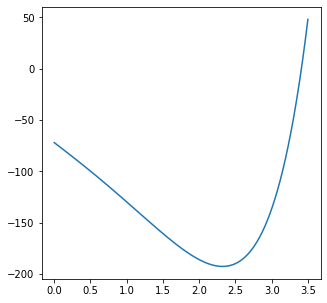

In [10]:
# Plot 1st order

X = np.linspace(0, 3.5, 10000)
Y = f(X)
plt.figure(figsize=(5, 5))
plt.plot(X, Y)

In [11]:
f'Minimum = {Y.min()}'

'Minimum = -192.62417989289128'

In [12]:
x0_test = [1, 2, 3, 100]

#### Baseline: Scipy optimize minimize using BFGS

In [13]:
for i in range(4):
    _min = minimize(
        fun=f, 
        x0=x0_test[i], 
        method='BFGS', 
        jac=lambda x: f(x, order=1)[1]
    )
    print(f'Min for x0={x0_test[i]}: {_min}\n')

Min for x0=1:       fun: -192.6241818307069
 hess_inv: array([[0.00641693]])
      jac: array([2.23244939e-07])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([2.32232458])

Min for x0=2:       fun: -192.62418183070685
 hess_inv: array([[0.00641877]])
      jac: array([9.86250981e-07])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.32232459])

Min for x0=3:       fun: -192.62418183070685
 hess_inv: array([[0.00641972]])
      jac: array([-1.26231838e-06])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([2.32232458])

Min for x0=100:       fun: -192.62418183070685
 hess_inv: array([[0.00640667]])
      jac: array([3.86298896e-06])
  message: 'Optimization terminated successfully.'
     nfev: 154
      nit: 153
     njev: 1

In [14]:
newton(
    func=f,
    initial_x=np.array([2]),
    linesearch=exact_line_search,
)

(array([2.32232458]),
 [-186.00601956150342, -192.62418183070687],
 [9.584426879882812e-05, 0.16667389869689941],
 [array([2]), array([2.32232458])])

#### Newton with backtracking

In [15]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=f,
        initial_x=np.array(x0_test[i]),
        linesearch=backtracking_line_search,
    )
    print(f'Min for x0={x0_test[i]}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')


Min for x0=1: -129.78721873678845, x_min=1, iters: 1
Min for x0=2: -192.62418157183197, x_min=[2.32238221], iters: 4
Min for x0=3: -192.62418182575078, x_min=[2.32233256], iters: 5
Min for x0=100: -192.62418183067095, x_min=[2.32232526], iters: 107


For $x_0=1$ the newton method stopped after 1 iter and stuck in non optimal value.

#### Newton with exact line search

In [16]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=f,
        initial_x=np.array(x0_test[i]),
        linesearch=exact_line_search,
    )
    print(f'Min for x0={x0_test[i]}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')

Min for x0=1: -129.78721873678845, x_min=1, iters: 1
Min for x0=2: -192.62418183070687, x_min=[2.32232458], iters: 2
Min for x0=3: -192.62418183070682, x_min=[2.32232458], iters: 2
Min for x0=100: -192.62418183070685, x_min=[2.32232458], iters: 2


Here also $x_0=1$ the newton method stopped after 1 iter and stuck in non optimal value.<br>
But we can see that for a bigger $x_0$ this linesearch did much less iterations.

### 2. Test on Boyd function

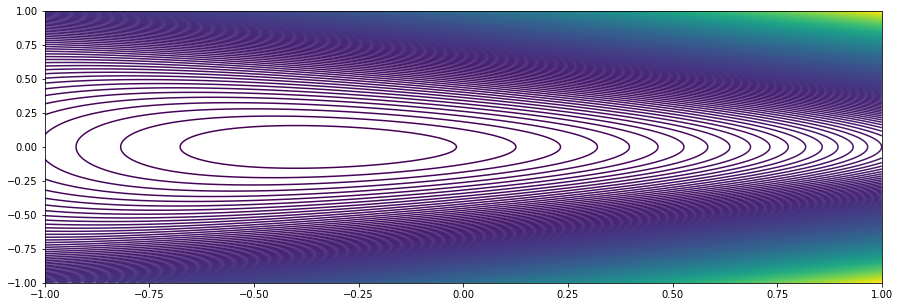

In [17]:
X, Y = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
Z = boyd_example_func(
    np.array([X, Y]).reshape(2, -1)
)
plt.figure(figsize=(15, 5))
plt.contour(X, Y, Z.reshape(X.shape), 400)

#### Baseline: Scipy optimize minimize using BFGS

In [18]:
for i in range(4):
    _min = minimize(
        fun=boyd_example_func, 
        x0=np.array([x0_test[i], x0_test[i]]), 
        method='BFGS', 
        jac=lambda x: boyd_example_func(x, order=1)[1]
    )
    print(f'Min for x0={x0_test[i]}: {_min}\n')

Min for x0=1:       fun: 2.559266696658241
 hess_inv: array([[ 0.38438359, -0.00349181],
       [-0.00349181,  0.08492073]])
      jac: array([-2.33999667e-07, -5.78452418e-07])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([-3.46573682e-01, -5.02272755e-08])

Min for x0=2:       fun: 2.55926669665822
 hess_inv: array([[0.39020076, 0.00100703],
       [0.00100703, 0.08491825]])
      jac: array([ 3.72727518e-08, -3.17726834e-07])
  message: 'Optimization terminated successfully.'
     nfev: 17
      nit: 16
     njev: 17
   status: 0
  success: True
        x: array([-3.46573576e-01, -2.75883565e-08])

Min for x0=3:       fun: 2.559266696659827
 hess_inv: array([[ 0.36223326, -0.0165859 ],
       [-0.0165859 ,  0.07716638]])
      jac: array([1.80723769e-06, 4.73519296e-06])
  message: 'Optimization terminated successfully.'
     nfev: 23
      nit: 22
     njev: 23
   status: 0
  success: True

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/var/folders/v0/z0w5_4_s5354s0p_4nbq_flw0000gn/T/ipykernel_21707/509576170.py:14: RuntimeWarning: overflow encountered in exp
  value = np.exp(a @ x - 0.1) + np.exp(b @ x - 0.1) + np.exp(c @ x - 0.1)
/var/folders/v0/z0w5_4_s5354s0p_4nbq_flw0000gn/T/ipykernel_21707/509576170.py:17: RuntimeWarning: overflow encountered in exp
  grad = a * np.exp(a @ x - 0.1) + b * np.exp(b @ x - 0.1) + c * np.exp(c @ x - 0.1)
/var/folders/v0/z0w5_4_s5354s0p_4nbq_flw0000gn/T/ipykernel_21707/509576170.py:17: RuntimeWarning: invalid value encountered in multiply
  grad = a * np.exp(a @ x - 0.1) + b * np.exp(b @ x - 0.1) + c * np.exp(c @ x - 0.1)
/var/folders/v0/z0w5_4_s5354s0p_4nbq_flw0000gn/T/ipykernel_21707/509576170.py:17: RuntimeWarning: invalid value encountered in add
  grad = a * np.exp(a @

#### Newton with backtracking

In [19]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=boyd_example_func,
        initial_x=np.array([x0_test[i], x0_test[i]]),
        linesearch=backtracking_line_search,
    )
    print(f'Min for x0={(x0_test[i], x0_test[i])}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')

Min for x0=(1, 1): 2.559266696697338, x_min=[-3.46570386e-01  2.12417725e-06], iters: 8
Min for x0=(2, 2): 2.5592666966983977, x_min=[-3.46570355e-01  2.15669954e-06], iters: 12
Min for x0=(3, 3): 2.5592666966984075, x_min=[-3.46570355e-01  2.15710999e-06], iters: 16
Min for x0=(100, 100): 1.1662219520131836e+173, x_min=[100.25360462  99.44912863], iters: 3


##### For big $x_0$ method stopped after 3 iters and returned a big value

#### Newton with exact line search

In [20]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=boyd_example_func,
        initial_x=np.array([x0_test[i], x0_test[i]]),
        linesearch=exact_line_search,
    )
    print(f'Min for x0={(x0_test[i], x0_test[i])}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')

Min for x0=(1, 1): 2.5592718033917827, x_min=[-0.34840778  0.00037347], iters: 15
Min for x0=(2, 2): 2.5592708184035167, x_min=[-0.34814994  0.00040478], iters: 16
Min for x0=(3, 3): 2.5592743193955134, x_min=[-0.34593323 -0.00110989], iters: 16
Min for x0=(100, 100): 2.55927085172022, x_min=[-0.34837555  0.        ], iters: 76


##### Here for big $x_0$ method returned a valid minimum, but in all cases it made more iterations/

### 3. Test on quadratic function

In [21]:
quadratic_fun = lambda x, order=0: quadratic(
    H=np.diag(np.arange(3) + 2), 
    b=np.ones(3), 
    x=x,
    order=order
)

#### Baseline: Scipy optimize minimize using BFGS

In [22]:
for i in range(4):
    _min = minimize(
        fun=quadratic_fun, 
        x0=np.array([x0_test[i], x0_test[i], x0_test[i]]), 
        method='BFGS', 
        jac=lambda x: quadratic_fun(x, order=1)[1]
    )
    print(f'Min for x0={x0_test[i]}: {_min}\n')

Min for x0=1:       fun: -0.5416666666664868
 hess_inv: array([[ 5.00015530e-01,  2.01702720e-05, -3.03319573e-05],
       [ 2.01702720e-05,  3.33359530e-01, -3.93939793e-05],
       [-3.03319573e-05, -3.93939793e-05,  2.50059240e-01]])
      jac: array([ 2.53902035e-07,  4.94637294e-07, -9.91777551e-07])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([-0.49999987, -0.33333317, -0.25000025])

Min for x0=2:       fun: -0.5416666666666666
 hess_inv: array([[ 5.00000000e-01, -3.33066907e-16,  3.46944695e-17],
       [-3.33066907e-16,  3.33333333e-01, -4.16333634e-17],
       [ 3.46944695e-17, -4.51028104e-17,  2.50000000e-01]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.5       , -0.33333333, -0.25      ])

Min for x0=3:       fun: -0.5416666666666303
 hess_inv: array([[ 5.01

#### Newton with backtracking

In [23]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=quadratic_fun,
        initial_x=np.array([x0_test[i], x0_test[i], x0_test[i]]),
        linesearch=backtracking_line_search,
    )
    print(f'Min for x0={(x0_test[i], x0_test[i])}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')

Min for x0=(1, 1): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(2, 2): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(3, 3): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(100, 100): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2


##### Method worked on all cases in only 2 iters.

#### Newton with exact line search

In [24]:
for i in range(4):
    _x, _values, _runtimes, _xs = newton(
        func=quadratic_fun,
        initial_x=np.array([x0_test[i], x0_test[i], x0_test[i]]),
        linesearch=exact_line_search,
    )
    print(f'Min for x0={(x0_test[i], x0_test[i])}: {_values[-1]}, x_min={_x}, iters: {len(_values)}')

Min for x0=(1, 1): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(2, 2): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(3, 3): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2
Min for x0=(100, 100): -0.5416666666666667, x_min=[-0.5        -0.33333333 -0.25      ], iters: 2


##### The same situation here, after 2 iters we got the optimum answer for every case

## Problem 5.2
(total 6 pts)

(2 pts) Complete the implementation of Conjugate gradients method (see [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$])

<details>
  <summary>Click to see the Congugate gradient method.</summary>
  <img src="https://i.ibb.co/Hxn9PmM/Nocedal-Wright-CG-FR.png">
</details>


```python

###############################################################################
def cg( func, initial_x, eps=1e-5, maximum_iterations=65536, linesearch=bisection, *linesearch_args  ):
    """ 
    Conjugate Gradient
    func:               the function to optimize It is called as "value, gradient = func( x, 1 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    
    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    m = len( initial_x )
    iterations = 0
    direction = np.asmatrix( np.zeros( initial_x.shape ) )
    
    # conjugate gradient updates
    while True:
        
        value, gradient = func( x , 1 )
        value = np.double( value )
        gradient = np.asarray( gradient )
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        # if ( TODO: TERMINATION CRITERION ): break
        
        # beta = TODO: UPDATE BETA
        
        # reset after #(dimensions) iterations
        if iterations % m == 0:
            beta = 0
        
        # direction = TODO: FLETCHER-REEVES CONJUGATE GRADIENT UPDATE
        
        t = linesearch(func, x, direction, iterations, *linesearch_args)
        
        x += t * direction

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    
    return (x, values, runtimes, xs)
```

Next, copy the function above but use the following Polak-Riberie formulae:
$$ \beta_{k+1}^{\mathtt{PR}} = \frac{\nabla f_{k+1}^T(\nabla f_{k+1} - \nabla f_k)}{\|f_k\|^2}$$

Observe that we applied the reset trick.
It is worth reading more implementation hints in section [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$].


(4 pts) Compare the efficiency (number of function/gradient evaluations) of FR and PR updates in CG method for Powell's optimization problem (PSF):
$$ \min_{-10 \leq x_i \leq 10} (x_1+10x_2)^2+5(x_3-x_4)^2+(x_2-2x_3)^4 + 10(x_1-x_4)^4,$$


Observe that $f(X^*)=0$ for $X^*=0$.

More info about PSF can be found, for example, here http://www.optimization-online.org/DB_FILE/2012/03/3382.pdf.

Compare your results with [Nocedal, Wright, *Numerical Optimization*, Table 5.1] (row XPOWELL)
<img width=50% src="https://i.ibb.co/6PVGJrS/Table51.png">

---

## Bonus (4 points)

**Problem 5.3 (2 pts)**
Show experimentally that affine invariance of Newton's method. 

Let $f:\mathbb{R}^n\to\mathbb{R}$ be a convex function.
Consider an affine transform $y\mapsto Ay + b$, where $A \in \mathbb{R}^{n\times n}$ is invertible and
$b \in \mathbb R^n$.

Define the function $g : \mathbb R^n \mapsto \mathbb{R}$ by $g(y) = f(Ay + b)$.
Denote by $x^{(k)}$ the k-th iterate of Newton’s method performed on $f$.
Denote by $y^{(k)}$ the k-th iterate of Newton’s method performed on $g$.
* Show that if $x^{(k)} = Ay^{(k)} + b$, then $x^{(k+1)} = Ay^{(k+1)} + b$.
* Show that Newton's decrement does not depend on the coordinates, i.e., show that $λ(x^{(k)}) = λ(y^{(k)} ).$

Together, this implies that Newton’s method is affine invariant. As an important consequence,
Newton’s method cannot be improved by a change of coordinates, unlike gradient descent.

---

**Problem 5.4 (2 pts)**
Show experimentally that conjugate gradient method is *not* affine invariant.


For example consider the quadratic (convex) function $f:\mathbb R^n \to \mathbb R$ as follows
$$ f(x) = \frac12 x^T H x - c^T x,$$
where $H$ positive semi-definite.

Consider an affine transformation $y\mapsto Ay$, where  $A \in \mathbb{R}^{n\times n}$ is invertible:
* Denote by $x^{(0)} , x^{(1)} , x^{(2)}$ the first three iterates of conjugate gradient descent on $f(x)$ initialized at $x^{(0)}$.
* Now, let $y^{(0)}$ be the point such that $x^{(0)} = Ay^{(0)}$. Denote by $y^{(0)} , y^{(1)} , y^{(2)}$ the first three iterates of conjugate gradient descent on $g(y) = f(Ay)$ initialized at $y^{(0)}$.
* Provide an explicit example of $H, A$ and $x^{(0)}$ such that $x^{(1)} \neq Ay^{(1)}$ and $x^{(2)} \neq Ay^{(2)}$.